In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
dominos = pd.read_csv('Dominos_Stock_Data.csv')

In [3]:
dominos

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-16,254.89,257.61,253.08,255.96,251.60,525200
1,2019-10-17,256.12,259.96,255.78,256.45,252.09,515100
2,2019-10-18,257.45,258.40,254.23,255.70,251.35,609900
3,2019-10-21,256.61,259.84,255.67,257.52,253.14,499600
4,2019-10-22,257.27,259.47,255.38,258.94,254.53,343100
...,...,...,...,...,...,...,...
500,2021-10-11,477.88,484.46,472.43,479.48,479.48,359600
501,2021-10-12,481.37,483.16,476.13,480.05,480.05,413500
502,2021-10-13,479.72,480.46,474.03,476.28,476.28,629700
503,2021-10-14,461.00,489.89,455.96,477.48,477.48,1518300


In [4]:
dominos.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [6]:
dominos = dominos[['Date', 'Close']]

In [7]:
dominos.head()

,Date,Close
0,2019-10-16,255.96
1,2019-10-17,256.45
2,2019-10-18,255.70
3,2019-10-21,257.52
4,2019-10-22,258.94


In [9]:
dominos['Date'] = pd.to_datetime(dominos.Date, format = '%Y/%m/%d')

<ipython-input-9-e89c2aaf1397>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dominos['Date'] = pd.to_datetime(dominos.Date, format = '%Y/%m/%d')


In [10]:
plot_dominos = dominos.set_index('Date')

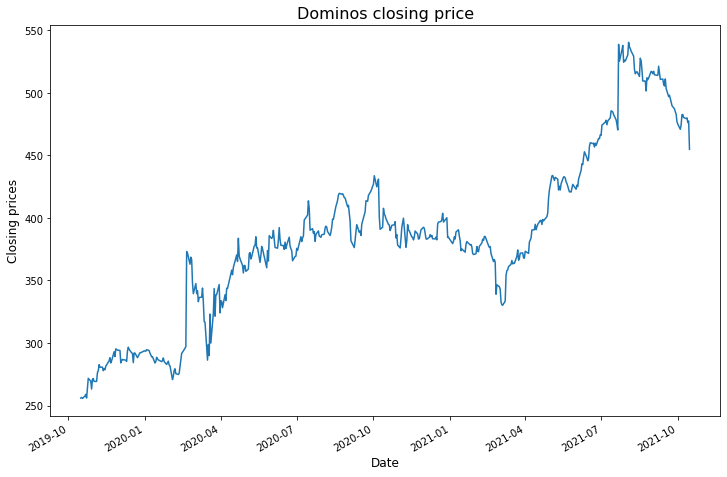

In [13]:
plot_dominos['Close'].plot(label='Closing price of dominos', figsize=(12,8))
plt.title('Dominos closing price', size=16)
plt.ylabel('Closing prices', size=12)
plt.xlabel('Date', size=12)
plt.show()

In [14]:
dominos = dominos.drop('Date', axis = 1)
dominos = dominos.reset_index(drop = True)

In [16]:
dominos.tail()

,Close
500,479.48
501,480.05
502,476.28
503,477.48
504,454.91


In [18]:
P = dominos.values
P = P.astype('float32')
P = np.reshape(P, (-1, 1))

## ........................................................................................................................................

In [19]:
scaler = MinMaxScaler(feature_range = (0, 1))
P = scaler.fit_transform(P)

In [20]:
train_size = int(len(P) * 0.80)
test_size = int(len(P) - train_size)
train, test = P[0:train_size,:], P[train_size:len(P),:]

In [21]:
def features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [23]:
window_size = 20
X_train, Y_train = features(train, window_size)
X_test, Y_test = features(test, window_size)

In [24]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [25]:
P_shape = P.shape
train_shape = train.shape
test_shape = test.shape

In [26]:
def isLeak(P_shape, train_shape, test_shape):
    return not(P_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(P_shape, train_shape, test_shape))

False


## ............................................................................................................................................

In [27]:
tf.random.set_seed(10)
np.random.seed(10)

In [28]:
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [29]:
filepath = 'saved_models/model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath = filepath, monitor = 'val_loss', verbose = 1, save_best_only = True, mode ='min')

history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, validation_data = (X_test, Y_test), 
                    callbacks = [checkpoint], verbose = 1, shuffle = False)
model.summary()

Epoch 1/100
20/20 [==============================] - 1s 10ms/step - loss: 0.0809 - val_loss: 0.1227

Epoch 00001: val_loss improved from inf to 0.12273, saving model to saved_models\model_epoch_01.hdf5
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0192

Epoch 00002: val_loss improved from 0.12273 to 0.01921, saving model to saved_models\model_epoch_02.hdf5
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0087

Epoch 00003: val_loss improved from 0.01921 to 0.00867, saving model to saved_models\model_epoch_03.hdf5
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0059

Epoch 00004: val_loss improved from 0.00867 to 0.00595, saving model to saved_models\model_epoch_04.hdf5
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0065

Epoch 00005: val_loss did not improve from 0.00595
Epoch 6/100
20/20 [=============

20/20 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0020

Epoch 00048: val_loss improved from 0.00246 to 0.00204, saving model to saved_models\model_epoch_48.hdf5
Epoch 49/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0031

Epoch 00049: val_loss did not improve from 0.00204
Epoch 50/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0041

Epoch 00050: val_loss did not improve from 0.00204
Epoch 51/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0049

Epoch 00051: val_loss did not improve from 0.00204
Epoch 52/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0047

Epoch 00052: val_loss did not improve from 0.00204
Epoch 53/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0044

Epoch 00053: val_loss did not improve from 0.00204
Epoch 54/100
20/20 [===========================

20/20 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0028

Epoch 00100: val_loss did not improve from 0.00180
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                14200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________


## ...............................................................................................................................................

In [31]:
from keras.models import load_model
best_model = load_model('saved_models/model_epoch_75.hdf5')

In [33]:
train_pred = best_model.predict(X_train)
Y_hat_train = scaler.inverse_transform(train_pred)

test_pred = best_model.predict(X_test)
Y_hat_test = scaler.inverse_transform(test_pred)

In [34]:
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [37]:
Y_hat_train = np.reshape(Y_hat_train, newshape = 383)
Y_hat_test = np.reshape(Y_hat_test, newshape = 80)

Y_train = np.reshape(Y_train, newshape = 383)
Y_test = np.reshape(Y_test, newshape = 80)

In [38]:
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_hat_train))
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

In [40]:
print('Train RMSE is: ')
print(train_rmse, '\n')
print('-' * 50)
print('Test RMSE is: ')
print(test_rmse)

Train RMSE is: 
12.244702633569696 

--------------------------------------------------
Test RMSE is: 
12.081103119030333


In [41]:
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

In [43]:
final_df = pd.DataFrame()

In [44]:
final_df['Actual_Y'] = Y
final_df['Predicted_Y'] = Y_hat

In [45]:
final_df.head()

,Actual_Y,Predicted_Y
0,279.399991,288.464691
1,278.660009,289.014984
2,281.410006,288.794312
3,284.609990,288.659485
4,285.739991,289.798065


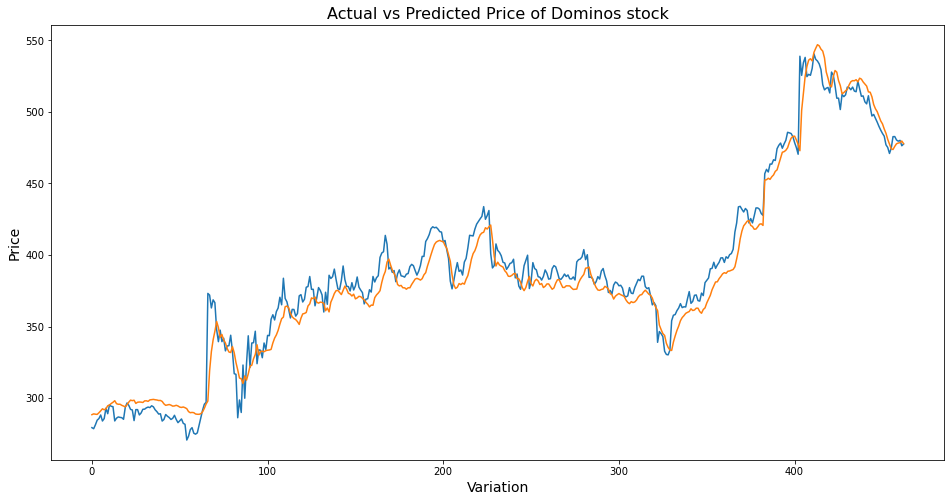

In [51]:
final_df['Actual_Y'].plot(label='Actual Price', figsize=(16,8))
final_df['Predicted_Y'].plot(label='Predicted Price')
plt.title('Actual vs Predicted Price of Dominos stock', size=16)
plt.ylabel('Price', size=14)
plt.xlabel('Variation', size=14)
plt.show()